### GAN Model v2

In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import split_sequence, get_apple_close_price, plot_series
from utils import plot_residual_forecast_error, print_performance_metrics
from utils import get_range, difference, inverse_difference
from utils import train_test_split

In [2]:
apple_close_price = get_apple_close_price()

In [3]:
short_series = get_range(apple_close_price, '2003-01-01')

In [4]:
# Model parameters
look_back = 5 # days window look back
n_features = 1 # our only feature will be Close price 
n_outputs = 5 # days forecast
batch_size = 32 # for NN, batch size before updating weights
n_epochs = 100 # for NN, number of training epochs

We need to first train/test split, then transform and scale our data

In [5]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [6]:
train, test= train_test_split(apple_close_price,'2018-05-31')

In [7]:
# boxcox_series, lmbda = boxcox(train.values)

In [8]:
# transformed_train = boxcox_series
# transformed_test = boxcox(test, lmbda=lmbda)

transformed_train = train.values
transformed_test = test.values

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
scaler = MinMaxScaler()

In [11]:
scaled_train = scaler.fit_transform(transformed_train.reshape(-1, 1))
scaled_test = scaler.transform(transformed_test.reshape(-1, 1))

In [12]:
X_train, y_train = split_sequence(scaled_train, look_back, n_outputs)
y_train = y_train.reshape(-1, n_outputs)

In [13]:
# Core layers
from keras.layers \
    import Activation, Dropout, Flatten, Dense, Input, LeakyReLU, Reshape

# Recurrent layers
from keras.layers import LSTM

# Convolutional layers
from keras.layers import Conv1D, MaxPooling1D

# Normalization layers
from keras.layers import BatchNormalization

# Merge layers
from keras.layers import concatenate

# Layer wrappers
from keras.layers import Bidirectional, TimeDistributed

# Keras models
from keras.models import Model, Sequential

# Keras optimizers
from keras.optimizers import Adam, RMSprop, SGD

import keras.backend as K

import warnings
warnings.simplefilter('ignore')

Using TensorFlow backend.


In [14]:
def build_generator(look_back, n_features=1, n_outputs=1):
    model = Sequential()

    model.add(LSTM(50, input_shape=(look_back, n_features)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(n_outputs))

    print('Generator summary:')
    model.summary()
    
    return model

In [15]:
def build_discriminator(look_back, n_features=1, n_outputs=1, optimizer=Adam()):
    features_input = Input((look_back, n_features))
    target_input = Input((n_outputs, 1))
    
    x = Conv1D(1, kernel_size=look_back, padding='same')(features_input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Flatten()(x)

#     y = Flatten()(target_input)
    
    y = Conv1D(1, kernel_size=n_outputs, padding='same')(target_input)
    y = LeakyReLU(alpha=0.2)(y)
    y = Flatten()(y)
    
    xy = concatenate([x, y])
    xy = Dense(32)(xy)
    xy = LeakyReLU(alpha=0.2)(xy)
    
    valid = Dense(1, activation='sigmoid')(xy)
    
    model = Model([features_input, target_input], valid);
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer)

    print('Discriminator summary:')
    model.summary()
    
    return model

In [16]:
def build_adversarial(look_back, 
                      n_features=1, n_outputs=1, 
                      dis_optimizer=Adam(), adv_optimizer=Adam()):
    
    discriminator = build_discriminator(look_back, n_features, n_outputs, optimizer=dis_optimizer)
    generator = build_generator(look_back, n_features, n_outputs)
    
    seq = Sequential()
    seq.add(generator)
    
    gen_input = Input((look_back, n_features))
    gen_output = seq(gen_input)
    gen_output = Reshape((n_outputs, 1))(gen_output)
    
    valid = discriminator([gen_input, gen_output])
    
    model = Model(gen_input, valid)
    
    discriminator.trainable = False # We need to freeze the discriminator's weights
    model.compile(loss='binary_crossentropy', optimizer=adv_optimizer)
    
    print('Adversarial summary:')
    model.summary()
    
    return model, discriminator, generator

In [17]:
adversarial, discriminator, generator = build_adversarial(look_back, 
                                                          n_features, 
                                                          n_outputs, 
                                                          dis_optimizer=Adam(lr=0.0001), 
                                                          adv_optimizer=Adam(lr=0.00001))

Discriminator summary:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5, 1)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 5, 1)         0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 5, 1)         6           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 5, 1)         6           input_2[0][0]                    
______________________________________________________________________________________

In [18]:
def get_batch(X, y, batch_idx, batch_size):
    '''
    Returns batches sequentially based on 
    the current batch_idx in the loop
    '''
    
    X_batch = X[batch_idx:batch_idx+batch_size]
    y_batch = y[batch_idx:batch_idx+batch_size]
    
    return X_batch, y_batch

In [19]:
def train_models(adv, dis, X_batch, y_batch, y_pred, n_outputs, n_features):
    '''
    Trains discriminator and adversarial (generator) models
    It's recommended to train the discriminator first with a 
    batch of real data and then train with a batch of fake data
    '''
    
    X_real = y_batch.reshape((y_batch.shape[0], n_outputs, n_features))
    X_fake = y_pred.reshape((y_pred.shape[0], n_outputs, 1))

#     y_real = np.full((y_batch.shape[0], 1), np.random.uniform(0.9, 1.1))
#     y_fake = np.full((y_pred.shape[0], 1), np.random.uniform(0, 0.2))
    
    y_real = np.ones((y_batch.shape[0], 1))
    y_fake = np.zeros((y_pred.shape[0], 1))

    # train discriminator:
    d_loss_real = dis.train_on_batch([X_batch, X_real], y_real)
    d_loss_fake = dis.train_on_batch([X_batch, X_fake], y_fake)
    d_loss = np.add(d_loss_real, d_loss_fake) / 2

    # train generator
    g_loss = adv.train_on_batch(X_batch, y_real)
    
    return d_loss_real, d_loss_fake, d_loss, g_loss

In [20]:
def train_GAN(X, y, 
              adv, dis, gen, 
              n_epochs=100, batch_size=100, 
              look_back=5, n_features=1, n_outputs=5):
    
    data_len = len(X)
    hist_d_loss_real = []; hist_d_loss_fake = []
    hist_d_loss = []; hist_g_loss = []
    
    for epoch in range(n_epochs):
        start = time.time()
        for batch_idx in range(0, data_len, batch_size):
            
            X_batch, y_batch = get_batch(X, y, batch_idx, batch_size)
            
            # laten space from a Gaussian distribution
#             noise = np.random.normal(0, 1, X_batch.shape)
            
            y_pred = gen.predict(X_batch)
            
            d_loss_real, d_loss_fake, d_loss, g_loss = train_models(adv, dis, 
                                                                    X_batch, y_batch, y_pred, 
                                                                    n_outputs, n_features)
        end = time.time()
        
        print ("Epoch %d/%d [D loss: %f] [G loss: %f] | %ds" % (epoch+1, n_epochs, d_loss, g_loss, end-start))
        
        hist_d_loss_real.append(d_loss_real); hist_d_loss_fake.append(d_loss_fake)
        hist_d_loss.append(d_loss); hist_g_loss.append(g_loss)
        
    return hist_d_loss_real, hist_d_loss_fake, hist_d_loss, hist_g_loss

In [21]:
hist_d_loss_real, hist_d_loss_fake, hist_d_loss, hist_g_loss = \
    train_GAN(X_train, y_train, 
              adversarial, discriminator, generator, 
              look_back=look_back, n_features=n_features, n_outputs=n_outputs, 
              n_epochs=n_epochs, batch_size=batch_size)

Epoch 1/100 [D loss: 0.495610] [G loss: 0.668364] | 11s
Epoch 2/100 [D loss: 0.431456] [G loss: 0.691247] | 6s
Epoch 3/100 [D loss: 0.389285] [G loss: 0.716188] | 6s
Epoch 4/100 [D loss: 0.360344] [G loss: 0.746100] | 6s
Epoch 5/100 [D loss: 0.338968] [G loss: 0.778625] | 6s
Epoch 6/100 [D loss: 0.327130] [G loss: 0.801527] | 6s
Epoch 7/100 [D loss: 0.323606] [G loss: 0.813795] | 6s
Epoch 8/100 [D loss: 0.327893] [G loss: 0.816126] | 6s
Epoch 9/100 [D loss: 0.341363] [G loss: 0.805539] | 6s
Epoch 10/100 [D loss: 0.362227] [G loss: 0.793253] | 6s
Epoch 11/100 [D loss: 0.391982] [G loss: 0.780965] | 6s
Epoch 12/100 [D loss: 0.428114] [G loss: 0.774518] | 6s
Epoch 13/100 [D loss: 0.471651] [G loss: 0.779816] | 6s
Epoch 14/100 [D loss: 0.515916] [G loss: 0.794144] | 6s
Epoch 15/100 [D loss: 0.560331] [G loss: 0.816576] | 6s
Epoch 16/100 [D loss: 0.593482] [G loss: 0.826508] | 6s
Epoch 17/100 [D loss: 0.613379] [G loss: 0.833761] | 6s
Epoch 18/100 [D loss: 0.620962] [G loss: 0.837250] | 6s


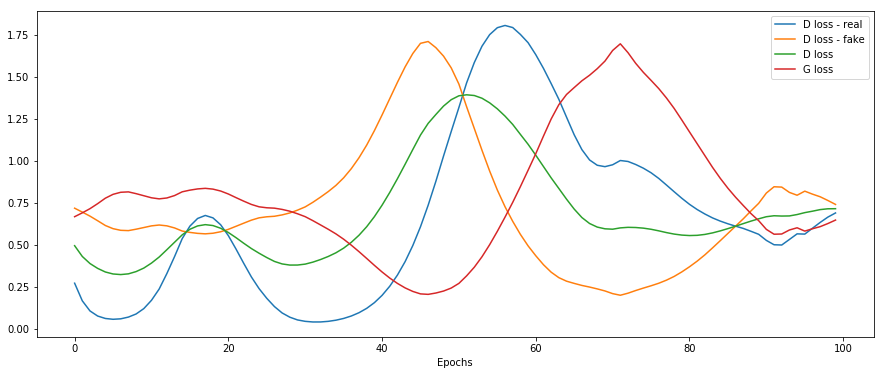

In [22]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(hist_d_loss_real)
plt.plot(hist_d_loss_fake)
plt.plot(hist_d_loss)
plt.plot(hist_g_loss)
ax.set_xlabel('Epochs')
ax.legend(['D loss - real', 
           'D loss - fake', 
           'D loss', 
           'G loss'])

In [23]:
generator.save_weights('gan_generator-model_weights.h5')
discriminator.save_weights('gan_discriminator-model_weights.h5')
adversarial.save_weights('gan_adversarial-model_weights.h5')

In [24]:
# # Walk Forward validation. Recursive Multi-step Forecast strategy
# # See https://machinelearningmastery.com/multi-step-time-series-forecasting/
# def GAN_walk_forward_validation(adv, dis, gen, 
#                                 train, test, 
#                                 size=1,
#                                 look_back=3, 
#                                 n_features=1, 
#                                 steps=1):
    
#     past = train.reshape(-1,).copy()
#     future = test.reshape(-1,)[:size]
    
#     predictions = list()
#     limit_range = len(future)
    
#     for t in range(0, limit_range, steps):
#         x_input = past[-look_back:] # grab the last look_back days from the past
        
#         preds_seq = []
        
#         for p in range(steps):
#             y_output = gen.predict(x_input.reshape(1, look_back, n_features))
            
#             y_output = y_output.reshape(-1,)
            
#             # save the prediction in the sequence
#             preds_seq.append(y_output)
            
#             # get rid of the first input (first day look back)
#             x_input = x_input[1:]
        
#             # appends the new predicted one
#             x_input = np.concatenate((x_input, y_output), axis=0)
        
#         predicted = np.array(preds_seq).reshape(steps,)
#         predictions.append(predicted)

#         # add the new n_outputs days (real ones) to the past
#         past = np.concatenate((past, future[t:t+steps]))
            
#     return np.array(predictions).reshape(-1,)[:limit_range]

In [25]:
def GAN_walk_forward_validation(adv, dis, gen, 
                                train, test, 
                                size=1, look_back=1, n_features=1, n_outputs=1):
    
    past = train.reshape(-1,).copy()
    future = test.reshape(-1,)[:size]
    
    predictions = list()
    limit_range = len(future)

    for t in range(0, limit_range, n_outputs):
        x_input = past[-look_back:] # grab the last look_back days from the past
        x_input = x_input.reshape(1, look_back, n_features)
        
        # predict the next n_outputs days
        y_hat = gen.predict(x_input)
        predictions.append(y_hat.reshape(n_outputs,))

        # add the next real days to the past
        past = np.concatenate((past, future[t:t+n_outputs]))
        
        if len(future[t:t+n_outputs]) == n_outputs:
            X_batch = x_input
            y_batch = future[t:t+n_outputs].reshape(-1, n_outputs)
        
            # Time to re-train the model with the new non-seen days
            # TODO: ??
            
    return np.array(predictions).reshape(-1,)[:limit_range]

In [26]:
size = 252 # approx. one year
predictions = GAN_walk_forward_validation(adversarial, discriminator, generator, 
                                          scaled_train, scaled_test, size=size,
                                          look_back=look_back, n_outputs=n_outputs)

In [27]:
from utils import plot_walk_forward_validation
from utils import plot_residual_forecast_error, print_performance_metrics

We need to revert the scaling and transformation:

In [28]:
descaled_preds = scaler.inverse_transform(predictions.reshape(-1, 1))
descaled_test = scaler.inverse_transform(scaled_test.reshape(-1, 1))

# descaled_preds = inv_boxcox(descaled_preds, lmbda)
# descaled_test = inv_boxcox(descaled_test, lmbda)

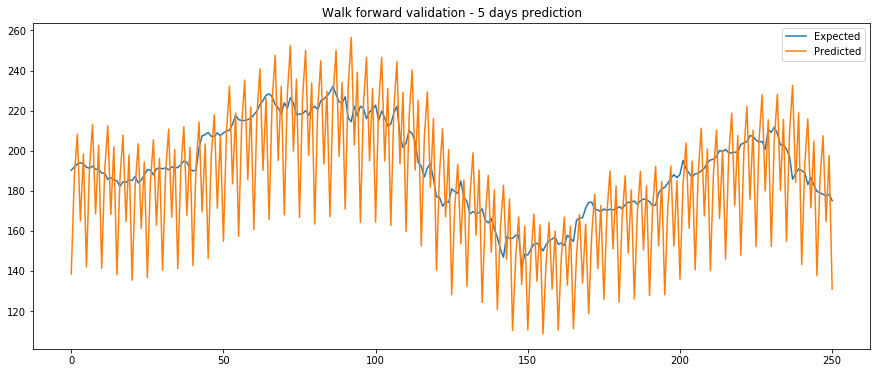

In [29]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(descaled_test[:size])
plt.plot(descaled_preds)
ax.set_title('Walk forward validation - 5 days prediction')
ax.legend(['Expected', 'Predicted'])

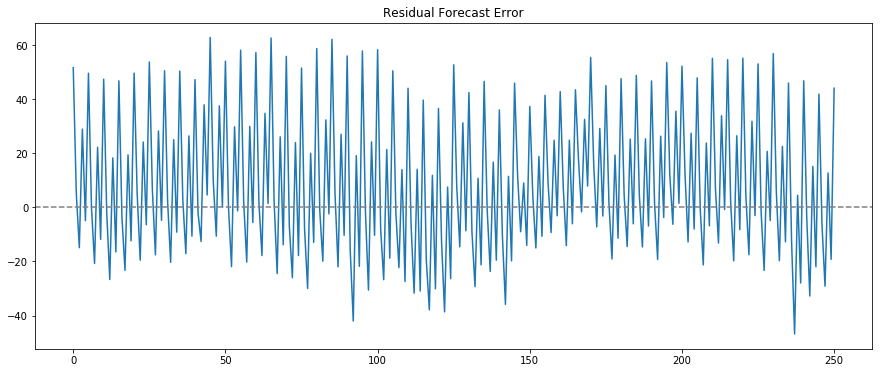

In [30]:
plot_residual_forecast_error(descaled_preds, descaled_test[:size])

In [31]:
print_performance_metrics(descaled_preds, 
                          descaled_test[:size],
                          model_name='GAN', 
                          total_days=size, steps=n_outputs)

GAN[252 days, 5 days forecast]:

Forecast Bias: 8.597
MAE: 22.574
MSE: 799.481
RMSE: 28.275
MAPE: 11.846


In [111]:
# generator.load_weights('gan_generator-model_weights.h5')
# discriminator.load_weights('gan_discriminator-model_weights.h5')
# adversarial.load_weights('gan_adversarial-model_weights.h5')